In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
plt.rcParams['figure.figsize'] = 15, 10

0it [00:00, ?it/s]

Extracting ./MNIST/train/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/train/MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/train/MNIST/raw
Processing...


/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


0it [00:00, ?it/s]

Extracting ./MNIST/test/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/test/MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/test/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/test/MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/test/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/test/MNIST/raw


0it [00:00, ?it/s]

Extracting ./MNIST/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/test/MNIST/raw
Processing...
Done!


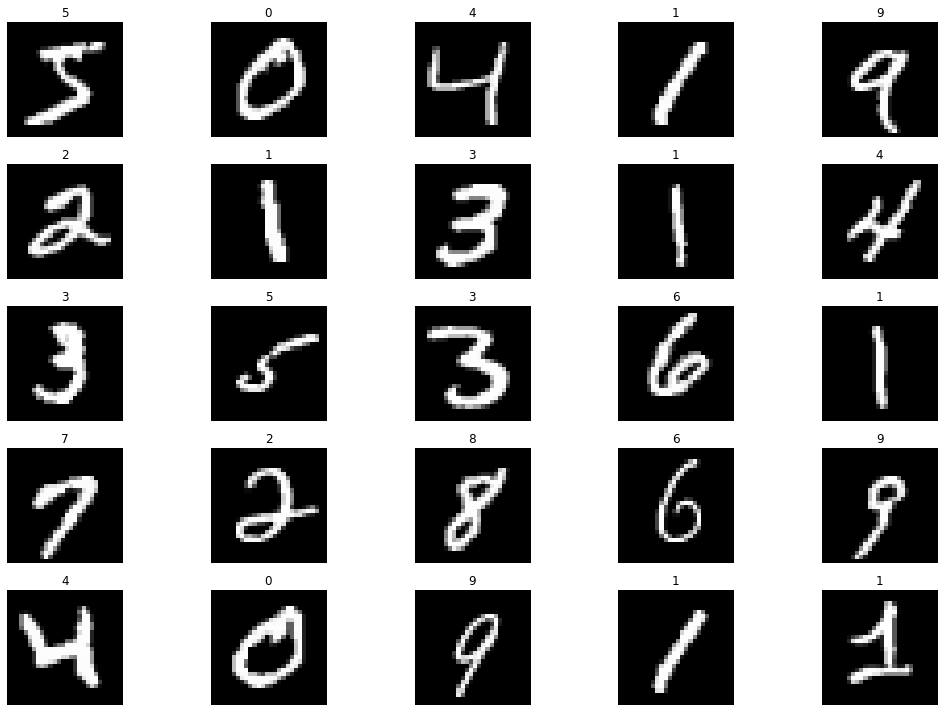

In [2]:
# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5), (0.5))
])

# Downloading the MNIST dataset
train_dataset = torchvision.datasets.MNIST(
    root="./MNIST/train", train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True)

test_dataset = torchvision.datasets.MNIST(
    root="./MNIST/test", train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True)

# Creating Dataloaders from the
# training and testing dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256)

# Printing 25 random images from the training dataset
random_samples = np.random.randint(
    1, len(train_dataset), (25))

for idx in range(random_samples.shape[0]):
    plt.subplot(5, 5, idx + 1)
    plt.imshow(train_dataset[idx][0][0].numpy(), cmap='gray')
    plt.title(train_dataset[idx][1])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 10)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
criterion = torch.nn.MSELoss()
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [5]:
from tqdm import trange

100%|██████████| 100/100 [31:23<00:00, 18.83s/it]


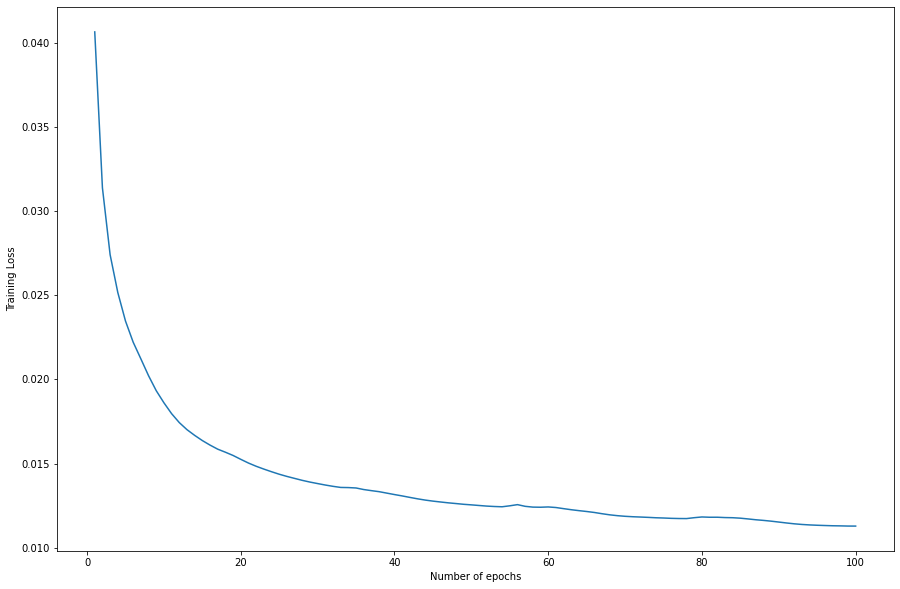

In [6]:
# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

batch_size = len(train_loader)

# Training loop starts
for epoch in trange(num_epochs):
        
    # Initializing variable for storing
    # loss
    running_loss = 0
    
    # Iterating over the training dataset
    for batch in train_loader:
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img, _ = batch
        img = img.reshape(-1, 28*28)
        
        # Generating output
        out = model(img)
        
        # Calculating loss
        loss = criterion(out, img)
        
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Incrementing loss
        running_loss += loss.item()
    
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
    
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}


# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

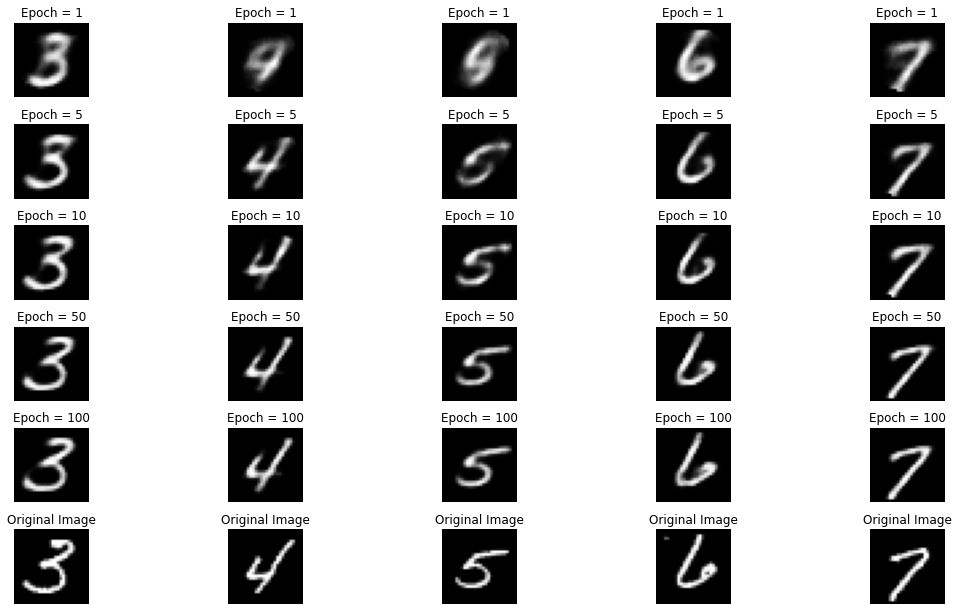

In [7]:
# Plotting is done on a 7x5 subplot
# Plotting the reconstructed images

# Initializing subplot counter
counter = 1

# Plotting reconstructions
# for epochs = [1, 5, 10, 50, 100]
epochs_list = [1, 5, 10, 50, 100]

# Iterating over specified epochs
for val in epochs_list:
    
    # Extracting recorded information
    temp = outputs[val]['out'].detach().numpy()
    title_text = f"Epoch = {val}"
    
    # Plotting first five images of the last batch
    for idx in range(5):
        plt.subplot(7, 5, counter)
        plt.title(title_text)
        plt.imshow(temp[idx].reshape(28,28), cmap= 'gray')
        plt.axis('off')
        
        # Incrementing the subplot counter
        counter+=1

# Plotting original images

# Iterating over first five
# images of the last batch
for idx in range(5):
    
    # Obtaining image from the dictionary
    val = outputs[10]['img']
    
    # Plotting image
    plt.subplot(7,5,counter)
    plt.imshow(val[idx].reshape(28, 28),
            cmap = 'gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Incrementing subplot counter
    counter+=1

plt.tight_layout()
plt.show()

In [54]:
# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

batch_size = len(train_loader)

# Training loop starts
# for epoch in trange(num_epochs):
        
    # Initializing variable for storing
    # loss
    # running_loss = 0
    
    # Iterating over the training dataset
for batch in train_loader:
    
    # Loading image(s) and
    # reshaping it into a 1-d vector
    img, _ = batch
    img = img.reshape(-1, 28*28)

    # Generating output
    out = model(img)
    break

(array([166211.,   2416.,   2173.,   1913.,   1997.,   2132.,   1913.,
          2249.,   2562.,  17138.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

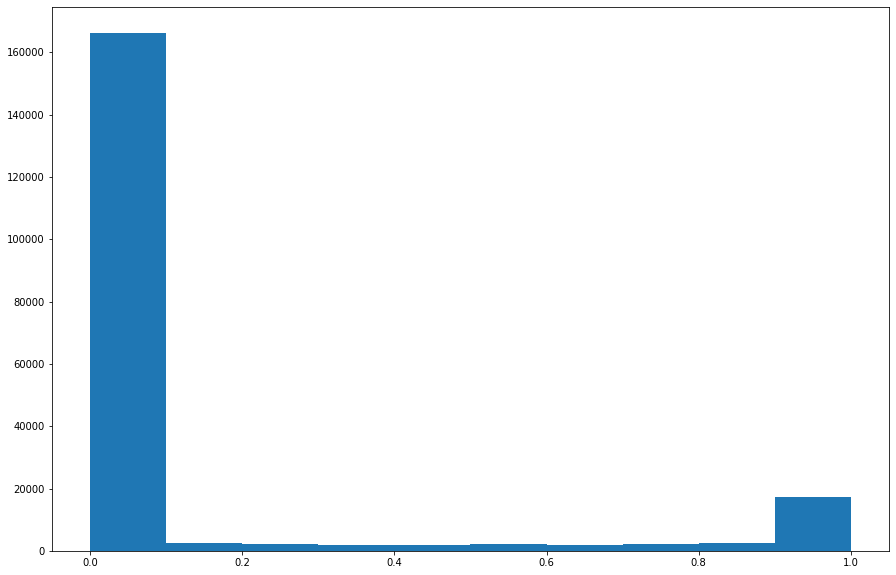

In [58]:
plt.hist(img.flatten())

In [103]:
batch_size = len(train_loader)

rs = []
for batch in tqdm(train_loader):
    
    # Loading image(s) and
    # reshaping it into a 1-d vector
    img, _ = batch
    img = img.reshape(-1, 28*28)

    # Generating output
    out = model(img)
    for i in range(28*28):
        pred = out.detach().cpu().numpy()[:,i]
        act = img.detach().cpu().numpy()[:,i]
        rs.append(r2_score(act,pred.round(2)))
#     break

100%|██████████| 235/235 [00:53<00:00,  4.40it/s]


In [107]:
rs_tr = np.array(rs).reshape(784,235)
pos = []
for m in np.mean(rs_tr, axis=1):
    if m.round(2) > 0:
        pos.append(m)
np.mean(pos),np.std(pos)

(0.563317950565016, 0.19932931189548547)

In [108]:
len(pos)

549

In [93]:
from sklearn.metrics import r2_score

In [95]:
from tqdm import tqdm

In [110]:
batch_size = len(test_loader)

rs = []
for batch in tqdm(test_loader):    
    # Loading image(s) and
    # reshaping it into a 1-d vector
    img, _ = batch
    img = img.reshape(-1, 28*28)

    # Generating output
    out = model(img)
    for i in range(28*28):
        pred = out.detach().cpu().numpy()[:,i]
        act = img.detach().cpu().numpy()[:,i]
        rs.append(r2_score(act,pred))

100%|██████████| 40/40 [00:08<00:00,  4.74it/s]


In [112]:
rs_tt = np.array(rs).reshape(784,40)
pos = []
for m in np.mean(rs_tt, axis=1):
    if m.round(2) > 0:
        pos.append(m)
np.mean(pos),np.std(pos)

(0.46214188232010184, 0.1812954661066912)

0.7206632653061225

In [109]:
rs_tt = np.array(rs).reshape(784,int(len(rs)/28/28))
np.mean(rs_tt.flatten()),np.std(rs_tt.flatten())

(-1.3692328976235004, 103.15084604942894)